#Library installation
only run this once

In [1]:
! pip install numpy
! pip install scikit-learn
! pip install heatmapz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.9 -m pip install --upgrade pip' command.


# Step 1 : Load Labled Data for training  (With urban quality score from survey reflecting sujective preference)

### load the labled data set into two data frames:
### df_Q - Dataframe for lables of subjective quality score that we try to predict
### df_F - Dataframe for objective feature values to inform the prediction.


Load the CSV with Subjective Scores (label/y/dependent variable) and Objective Feature Values (X feature space/ independent variables) 

In [25]:
### Read BerlinTraining Data, please swap the Berlin file with the local file of your collection
import pandas as pd
df= pd.read_csv("Berlin_Data_forTraining/Berlin_Continuous.csv",encoding='utf-8') #, engine='python''gb2312','utf-8'
print(df.shape,df.columns)
df.head(2)

(300, 46) Index(['ID', 'JPG_ID', 'Lat', 'Lng', 'Q1_Text', 'Q1_Type', 'Q2_Order',
       'Q3_Access', 'Q4_Aesth', 'Q5_Eco', 'Q6_Enclo', 'Q7_Richness',
       'Q8_Scale', 'wall', 'building', 'sky', 'tree', 'road', 'sidewalk',
       'grass', 'earth', 'signboard', 'plant', 'fence', 'streetlight',
       'mountain', 'railing', 'column', 'bridge', 'water', 'ashcan', 'awning',
       'windowpane', 'skyscraper', 'ct_person', 'ct_bicycle', 'ct_car',
       'ct_motorcycle', 'ct_truck', 'ct_traffic light', 'ct_bus', 'ct_bench',
       'ct_boat', 'ct_stop sign', 'ct_parking meter', 'ct_dining table'],
      dtype='object')


,ID,JPG_ID,Lat,Lng,Q1_Text,Q1_Type,Q2_Order,Q3_Access,Q4_Aesth,Q5_Eco,...,ct_car,ct_motorcycle,ct_truck,ct_traffic light,ct_bus,ct_bench,ct_boat,ct_stop sign,ct_parking meter,ct_dining table
0,0,0,52.511540,13.305022,Comm,2,0.778286,0.840392,0.599666,0.360809,...,36,1,1,0,0,0,0,0,0,0
1,1,1,52.417602,13.140238,Rural,5,0.480052,0.260063,0.461102,0.611198,...,2,0,0,0,0,0,0,0,0,0


### Locate the lists of subjective quality scores that we try to predict into df_Q

To seperate contents of dataframe 'df' between row number x_1 to x_2, and between colunm number y_1 to y_2, then store them in 'df_Q'

df_Q=df.iloc[x_1:x_2, y_1:y_2]


To seperate contents of dataframe 'df' between row number x_1 to x_2, and keep all the colunms, then store them in dataframe 'df_Q'

df_Q=df.iloc[x_1:x_2, :]


To seperate contents of dataframe 'df' between colunm number y_1 to y_2, and keep all the rows, then store them in 'df_Q'

df_Q=df.iloc[:, y_1:y_2]

In [26]:
#df_Q=df.iloc[:, 5:13] # please swap the colunm number here to the score of subjective features that you are trying to predict
df_Q=df[['Q1_Type', 'Q2_Order','Q3_Access','Q4_Aesth','Q5_Eco','Q6_Enclo','Q7_Richness','Q8_Scale']]
df_Q.head(2) #this line prints first two row of the data frame

,Q1_Type,Q2_Order,Q3_Access,Q4_Aesth,Q5_Eco,Q6_Enclo,Q7_Richness,Q8_Scale
0,2,0.778286,0.840392,0.599666,0.360809,0.578130,0.714419,0.684783
1,5,0.480052,0.260063,0.461102,0.611198,0.310256,0.130178,0.257246


### Locate the list of urban objective features that we want to use for prediction into df_F

To load certain colunm of dataframe 'df' into 'df_F' by selecting keys:

df_F=df[['sky', 'road','sidewalk','tree','plant','building','grass','wall','earth','fence']]

you can swap the keys to your desired keys.

In [27]:
#df_F=df.iloc[:,13:34] # please swap the colunm number here to the score urban features to inform prediction
df_F=df[['sky', 'road','sidewalk','tree','plant','building','grass','wall','earth','fence']] # please change the lables to the most significant features.


print(df_F.shape)
df_F.head(2) #this line prints first two row of the data frame

(300, 10)


,sky,road,sidewalk,tree,plant,building,grass,wall,earth,fence
0,0.189527,0.350102,0.011617,0.190051,0.0,0.171141,0.000000,0.002605,0.000000,0.0
1,0.127801,0.307738,0.000000,0.392734,0.0,0.000000,0.113199,0.000000,0.046516,0.0


#STEP 2: Train models that predicts the subjective quality and select the best one


### apply following ML models for prediction of all qualities:
KNN, SVM, Random Forest, Decision Tree, OLS, Gaussian, Voting Selection, GradientBoosting, ADA Boost, Bagging Regression 


### The following paramters of each trained model is documented for evaluation:

R2 - R-squared values range from 0 to 1 and are commonly stated as percentages from 0% to 100%. An R-squared of 100% means that all changes in the subjective rating are completely explained by the changes in the objective physical features.

RMSE - Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). it tells you how concentrated the data is around the line of best fit. ( Lower values are better)

MAE - Mean Absolute Error (MAE), similar to RMSE, MAE tell us how accurate our predictions are and, what is the amount of deviation from the actual values. ( Lower values are better)

In [29]:
### Divide data for training & testing on Question 2-8
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pickle
df_result=pd.DataFrame()

for i in range(len(df_Q.columns))[0:]:
    tag='Berlin_TrainedModels/'+str(i)
    print (df_Q.columns[i])
    
    X = df_F.values  
    Y = df_Q.iloc[:,i].values #Quality Score at Colunm i
    xTr, xTe, yTr, yTe = train_test_split(X, Y, test_size=0.20)
    yTr,yTe=(yTr.ravel(),yTe.ravel())
    print(xTr.shape,xTe.shape)
    print(type(yTr))

    #KNN
    from sklearn.neighbors import KNeighborsRegressor
    KNN=KNeighborsRegressor().fit(xTr, yTr) #n_neighbors=2
    yPr=KNN.predict(xTe)
    filename = tag+'_model_KNN.sav'
    pickle.dump(KNN, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | KNN"%(r2,rmse,mae),'\n') # SVM_Reg.get_params
    df_result.loc[i,'KNN_R2']=r2
    df_result.loc[i,'KNN_RMSE']=rmse
    df_result.loc[i,'KNN_MAE']=mae

    #SVM
    from sklearn.svm import SVR
    SVM_Reg = SVR().fit(xTr,yTr)
    yPr=SVM_Reg.predict(xTe)
    filename = tag+'_model_SVM.sav'
    pickle.dump(SVM_Reg, open(filename, 'wb'))

    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | SVM"%(r2,rmse,mae),'\n') # SVM_Reg.get_params
    df_result.loc[i,'SVM_R2']=r2
    df_result.loc[i,'SVM_RMSE']=rmse
    df_result.loc[i,'SVM_MAE']=mae

    #Random Forest
    from sklearn.ensemble import RandomForestRegressor
    RandomForest = RandomForestRegressor().fit(xTr,yTr)
    yPr=RandomForest.predict(xTe)
    filename = tag+'_model_RandomForest.sav'
    pickle.dump(RandomForest, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | Random Forest"%(r2,rmse,mae),'\n')
    df_result.loc[i,'RF_R2']=r2
    df_result.loc[i,'RF_RMSE']=rmse
    df_result.loc[i,'RF_MAE']=mae

    #Decision Tree
    from sklearn.tree import DecisionTreeRegressor
    DecisionTree= DecisionTreeRegressor(criterion='absolute_error',max_depth=2,random_state=10).fit(xTr, yTr)
    yPr=DecisionTree.predict(xTe)
    filename = tag+'_model_DecisionForest.sav'
    pickle.dump(DecisionTree, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | Decision Tree"%(r2,rmse,mae),'\n')
    df_result.loc[i,'DTree_R2']=r2
    df_result.loc[i,'DTree_RMSE']=rmse
    df_result.loc[i,'DTree_MAE']=mae

    #Linear Regression
    from sklearn.linear_model import LinearRegression
    lireg = LinearRegression().fit(xTr, yTr)
    yPr=lireg.predict(xTe)
    filename = tag+'_model_LinearRegression.sav'
    pickle.dump(lireg, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | OLS"%(r2,rmse,mae),'\n')
    df_result.loc[i,'LR_R2']=r2
    df_result.loc[i,'LR_RMSE']=rmse
    df_result.loc[i,'LR_MAE']=mae

    #Gaussian Process
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import DotProduct,WhiteKernel
    kernel = DotProduct() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(xTr, yTr)
    gpr.score(xTr, yTr)
    yPr=gpr.predict(xTe, return_std=True)
    yPr=yPr[0]
    filename = tag+'_model_Gaussian_Process.sav'
    pickle.dump(gpr, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | Gaussian"%(r2,rmse,mae),'\n')
    df_result.loc[i,'Gaus_R2']=r2
    df_result.loc[i,'Gaus_RMSE']=rmse
    df_result.loc[i,'Gaus_MAE']=mae

    #Voting Selection
    from sklearn.ensemble import VotingRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import VotingRegressor
    
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    er = VotingRegressor([('lr', r1), ('rf', r2)]).fit(xTr, yTr)
    yPr=er.predict(xTe)
    filename = tag+'_model_Voting_Selection.sav'
    pickle.dump(er, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s | Voting Selection"%(r2,rmse,mae),'\n')
    df_result.loc[i,'VtSel_R2']=r2
    df_result.loc[i,'VtSel_RMSE']=rmse
    df_result.loc[i,'VtSel_MAE']=mae



    # ADA Boost Regression
    from sklearn.ensemble import AdaBoostRegressor
    adaBst = AdaBoostRegressor(random_state=0, n_estimators=100).fit(xTr,yTr)
    #adaBst.feature_importances_
    yPr=adaBst.predict(xTe)
    filename = tag+'_model_ADABoosting_Regression.sav'
    pickle.dump(adaBst, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s |ADA Boost"%(r2,rmse,mae),'\n')
    df_result.loc[i,'AB_R2']=r2
    df_result.loc[i,'AB_RMSE']=rmse
    df_result.loc[i,'AB_MAE']=mae

    # BagingRegressor
    from sklearn.svm import SVR
    from sklearn.ensemble import BaggingRegressor
    regr = BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0).fit(xTr, yTr)
    yPr=regr.predict(xTe)
    filename = tag+'_model_BagingRegressor.sav'
    pickle.dump(regr, open(filename, 'wb'))
    
    r2=round(r2_score(yTe,yPr),2)
    rmse=round(np.sqrt(np.sum((yPr-yTe)**2)/len(yPr)),2)
    mae=round(np.sum(np.sqrt((yPr-yTe)**2))/len(yPr),2)
    print("R2:%s, RMSE:%s, MAE:%s |Bagging Regression"%(r2,rmse,mae),'\n')
    df_result.loc[i,'BR_R2']=r2
    df_result.loc[i,'BR_RMSE']=rmse
    df_result.loc[i,'BR_MAE']=mae

Q1_Type
(240, 10) (60, 10)
<class 'numpy.ndarray'>
R2:0.45, RMSE:1.4, MAE:1.03 | KNN 

R2:0.55, RMSE:1.27, MAE:0.96 | SVM 

R2:0.64, RMSE:1.14, MAE:0.89 | Random Forest 

R2:0.35, RMSE:1.52, MAE:0.88 | Decision Tree 

R2:0.5, RMSE:1.34, MAE:1.09 | OLS 

R2:0.31, RMSE:1.57, MAE:1.3 | Gaussian 

R2:0.56, RMSE:1.26, MAE:0.98 | Voting Selection 

R2:0.48, RMSE:1.36, MAE:1.24 |ADA Boost 

R2:0.57, RMSE:1.24, MAE:0.96 |Bagging Regression 

Q2_Order
(240, 10) (60, 10)
<class 'numpy.ndarray'>
R2:-0.1, RMSE:0.2, MAE:0.16 | KNN 

R2:-0.15, RMSE:0.2, MAE:0.17 | SVM 

R2:-0.12, RMSE:0.2, MAE:0.16 | Random Forest 

R2:-0.23, RMSE:0.21, MAE:0.17 | Decision Tree 

R2:0.02, RMSE:0.19, MAE:0.15 | OLS 

R2:0.03, RMSE:0.19, MAE:0.15 | Gaussian 

R2:-0.06, RMSE:0.2, MAE:0.16 | Voting Selection 

R2:-0.01, RMSE:0.19, MAE:0.16 |ADA Boost 

R2:-0.12, RMSE:0.2, MAE:0.17 |Bagging Regression 

Q3_Access
(240, 10) (60, 10)
<class 'numpy.ndarray'>
R2:0.17, RMSE:0.19, MAE:0.16 | KNN 

R2:0.29, RMSE:0.18, MAE:0.15 

### Save the performance chart of different models for different quality predictions in an excel

In [6]:
df_result.to_csv('Berlin_TrainedModels/Example_ModelSelection_Continuous.csv', index=False, encoding='utf-8')
df_result

,KNN_R2,KNN_RMSE,KNN_MAE,SVM_R2,SVM_RMSE,SVM_MAE,RF_R2,RF_RMSE,RF_MAE,DTree_R2,...,Gaus_MAE,VtSel_R2,VtSel_RMSE,VtSel_MAE,AB_R2,AB_RMSE,AB_MAE,BR_R2,BR_RMSE,BR_MAE
0,0.40,1.36,1.08,0.53,1.21,0.97,0.62,1.08,0.84,0.35,...,1.27,0.59,1.12,0.92,0.49,1.26,1.13,0.53,1.21,0.97
1,-0.00,0.20,0.16,0.07,0.20,0.16,0.07,0.20,0.16,-0.05,...,0.15,0.05,0.20,0.16,0.07,0.20,0.16,0.08,0.20,0.16
2,0.12,0.19,0.16,0.15,0.19,0.15,0.14,0.19,0.15,0.06,...,0.15,0.16,0.19,0.15,0.09,0.20,0.16,0.18,0.19,0.15
3,-0.00,0.19,0.15,-0.12,0.21,0.16,-0.04,0.20,0.15,-0.23,...,0.14,0.08,0.19,0.14,-0.02,0.20,0.15,0.03,0.19,0.15
4,0.27,0.19,0.15,0.36,0.18,0.13,0.30,0.19,0.14,0.09,...,0.13,0.37,0.18,0.14,0.34,0.18,0.14,0.37,0.18,0.13
5,0.46,0.17,0.14,0.49,0.17,0.14,0.53,0.16,0.13,0.30,...,0.12,0.56,0.16,0.12,0.46,0.17,0.14,0.50,0.17,0.13
6,0.05,0.18,0.16,0.08,0.18,0.14,-0.09,0.20,0.16,-0.12,...,0.15,-0.01,0.19,0.16,0.07,0.18,0.15,0.09,0.18,0.14
7,0.23,0.18,0.14,0.34,0.16,0.13,0.22,0.18,0.14,-0.07,...,0.14,0.28,0.17,0.14,0.26,0.17,0.14,0.34,0.16,0.13


# STEP 3: Select the best model and evaluate the importance of different features


### Rank the features by feature importance

  ExtTree_Feature  ExtTree_Score  ExtTree_Sort
9             sky       0.324425           1.0
8            road       0.142558           2.0
7           plant       0.115192           3.0
6        sidewalk       0.075983           4.0
5        building       0.073947           5.0
4            tree       0.064153           6.0
3           grass       0.060231           7.0
2            wall       0.057075           8.0
1           earth       0.047599           9.0
0           fence       0.038835          10.0


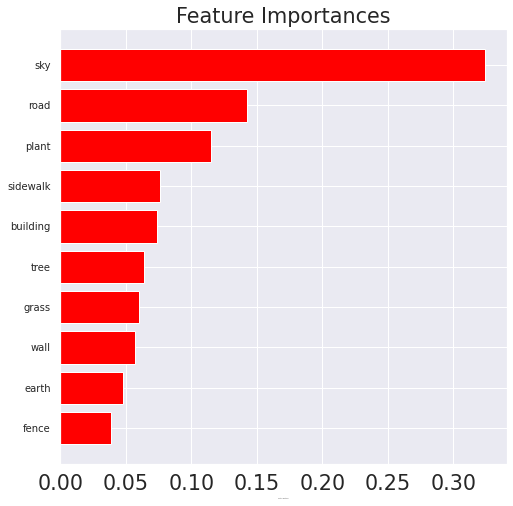

In [21]:
#Please swap the path to the best performing model that you would like to use

with open('Berlin_TrainedModels/7_model_RandomForest.sav', 'rb') as f:
    BestModel = pickle.load(f)


IMPT = BestModel.feature_importances_
RANK = np.argsort(IMPT)
FEATURES=df_F.columns
Tree_Imprtnc= pd.DataFrame()

for i in range(len(RANK)):    
    Tree_Imprtnc.loc[i,'ExtTree_Feature']=FEATURES[RANK[i]]
    Tree_Imprtnc.loc[i,'ExtTree_Score']=IMPT[RANK[i]]
    Tree_Imprtnc.loc[i,'ExtTree_Sort']=len(RANK)-i
Tree_Imprtnc_Rev=Tree_Imprtnc.iloc[::-1]    
print(Tree_Imprtnc_Rev.head(10))
Tree_Imprtnc.to_csv('Importance_Safety.csv', index=False, encoding='utf-8')

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-small'} 
# Size options: xx-small,x-small,small,medium,large,x-large,xx-large
pylab.rcParams.update(params)

plt.title('Feature Importances')
plt.barh(range(len(RANK)), IMPT[RANK], color='red', align='center')
plt.yticks(range(len(RANK)), [FEATURES[i] for i in RANK])
plt.xlabel('Relative Importance',fontsize=0.01)
plt.show()

### Plot correlation matrix heatmap for the data set

### NOTE: This onl need original dataset, not the trained model.

https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 7,7 
import seaborn as sns
import numpy as np
sns.set(color_codes=True, font_scale=1.2)

# Import the two methods from heatmap library
from heatmap import heatmap, corrplot



(398, 18)

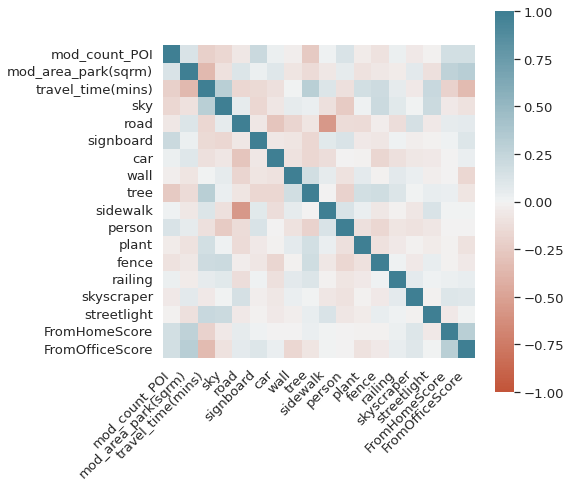

In [24]:
data = pd.read_csv("Work_from_home_14-03-2022.csv",encoding='utf-8') #, engine='python''gb2312','utf-8'

data = data[['mod_count_POI','mod_area_park(sqrm)','travel_time(mins)','sky','road','signboard','car', 'wall','tree','sidewalk','person','plant','fence','railing','skyscraper','streetlight','FromHomeScore','FromOfficeScore']]
#latitude	longitude	Name	area_index	mod_count_POI	count_station	mod_area_park(㎡)	distance_cityCenter(m)	travel_time(mins)	FromHomeScore	FromOfficeScore	building	sky	ceiling	road	car	signboard	wall	tree	sidewalk	person	earth	mountain	plant	chair	fence	railing	ashcan	skyscraper	bridge	streetlight	pier	minibike	grass	van	awning	water	windowpane	column	fountain	bicycle	lake	booth	sofa	sculpture	lamp	bulletin board

corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
data.shape

#======================================================